<div style="line-height:1.2;">

<h1 style="color:#FF7C00; margin-bottom: 0.3em;">Transformers Neural Networks in TensorFlow</h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;"> Text translation from Italian to Portoguese with a custom Transformer model.</h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    tensorflow_datasets + tokenization + encoding + mask + $$\Large formula markdown + matplotlib pcolormesh + <br> numpy set_printoptions + tf.keras.Model + LearningRateSchedule + @tf.function decorators 
</div>

</div>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/it_to_pt', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/46259 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/it_to_pt/1.0.0.incompleteGT2AWD/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1162 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/it_to_pt/1.0.0.incompleteGT2AWD/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/it_to_pt/1.0.0.incompleteGT2AWD/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/it_to_pt/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
num_examples_train = train_examples.cardinality().numpy()
num_examples_train

46259

In [ ]:
num_examples_val = val_examples.cardinality().numpy()
num_examples_val

1162

In [ ]:
type(train_examples)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
#for elem in train_examples(10): #not callable!
for elem in train_examples.take(10):
  print(elem)


(<tf.Tensor: shape=(), dtype=string, numpy=b'sulle scatole grigie non gira windows hanno una tecnologia completamente diversa .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'as caixas cinzentas n\xc3\xa3o utilizam o software windows ; s\xc3\xa3o uma tecnologia completamente diferente .'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'e come fare per la nostra paura ?'>, <tf.Tensor: shape=(), dtype=string, numpy=b'e ent\xc3\xa3o o nosso medo ?'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'vi dar\xc3\xb2 un paio di secondi .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'vou dar-vos alguns segundos .'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'e non sono i soli .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'e n\xc3\xa3o s\xc3\xa3o os \xc3\xbanicos .'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'e chiaramente , alla fine , le cose si sono sistemate .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'e , claro , as coisas acabaram por correr bem .'>)
(<tf.Tensor: shape=(), dtype=str

In [ ]:
for elem in val_examples.take(10):
  print(elem)

(<tf.Tensor: shape=(), dtype=string, numpy=b'li vedevano come un modo di pensare .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'viam-no como uma reflex\xc3\xa3o .'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'in corea del nord , la creai io .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'na coreia do norte , eu fi-lo sozinho .'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b"`` per questo il tuo lavoro ha un posto molto speciale nel mio cuore ed \xc3\xa8 molto importante per me '' '' . una donna ha condiviso il suo ritratto su facebook scrivendo : `` '' per tutta la vita , le persone in tutto il mondo avevano difficolt\xc3\xa0 a inserirmi in un gruppo , uno stereotipo , una casella . ''">, <tf.Tensor: shape=(), dtype=string, numpy=b"`` `` '' por isso , o seu trabalho tem um lugar muito especial no meu cora\xc3\xa7\xc3\xa3o `` e \xc3\xa9 muito importante para mim . '' uma mulher partilhou o seu retrato no facebook e escreveu : `` '' toda a minha vida , `` '' as pessoas por todo o mu

<div style="line-height:0.3">
<h3 style="color:#FF7C00  ">  Subword tokenization with a fixed vocab size </h3>
<div style="line-height:1">

+ Build the SubwordTextEncoder tokenizer.
+ Set the target vocabulary size to 2^13 subwords.       
</div>
</div>
The tokenizer will learn a vocabulary of size 2^13 subwords from the training corpus.

In [ ]:
""" Create tokenizers """
tokenizer_it = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (it.numpy() for it, pt in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for it, pt in train_examples), target_vocab_size=2**13)

In [ ]:
sample_string_present = 'viam-no como uma reflex.'
sample_string = 'há mau tempo hoje.'

tokenized_string = tokenizer_pt.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_pt.decode(tokenized_string)
print('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [47, 3951, 171, 284, 7903]
The original string: há mau tempo hoje.


In [ ]:
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_pt.decode([ts])))

47 ----> há 
3951 ----> mau 
171 ----> tempo 
284 ----> hoje
7903 ----> .


In [ ]:
sample_string = 'Transformers eles são úteis.'
tokenized_string = tokenizer_pt.encode(sample_string)
original_string = tokenizer_pt.decode(tokenized_string)

print('Tokenized string is {}'.format(tokenized_string))
print('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7941, 3240, 7972, 2295, 1307, 7889, 67, 34, 4456, 7903]
The original string: Transformers eles são úteis.


In [ ]:
# Tokens can be broken down if the word is not present in the dictionary. => T, ran, s, form. ers
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_pt.decode([ts])))

7941 ----> T
3240 ----> ran
7972 ----> s
2295 ----> form
1307 ----> ers
7889 ---->  
67 ----> eles 
34 ----> são 
4456 ----> úteis
7903 ----> .


In [ ]:
BUFFER_SIZE = 100 #20000
BATCH_SIZE = 4 #64

<h2 style="color:#FF7C00  "> <b> Encoding </b></h2>

In [ ]:
def encode_tokenizer(lang1, lang2):
    """ Encodes two language strings to sequences of subword ids.
    Add a start and end token to the input and target.

    Parameters:
        - Tensor containing text in language 1.
        - Tensor containing text in language 2.

    Details:
        For both languages:
        - Add special start token index (tokenizer vocab size) to start of lang1 encoding.
            - lang1 need to be converted from a tensor to numpy string to be encoded
            - Add special end token index (vocab size + 1) to end of lang1 encoding

    Returns:
        - list of subword ids for language 1 with start/end tokens
        - list of subword ids for language 2 with start/end tokens
    """
    ## Special start token index for lang1 and lang2
    lang1 = [tokenizer_it.vocab_size] + tokenizer_it.encode(lang1.numpy()) + [tokenizer_it.vocab_size+1]
    lang2 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang2.numpy()) + [tokenizer_pt.vocab_size+1]

    return lang1, lang2

<h3 style="color:#FF7C00"> Recap: </h3>
<div style="margin-top: -8px;">
Graph tensors don't have a value. In graph mode you can only use TensorFlow Ops and functions. <br>
So the function cannot be mapped directly, to apply a function to each element of the dataset, since Dataset.map runs in graph mode.

The function must be wrapped it in a "tf.py_function" to pass a regular tensors to the wrapped python function.
</div>

In [ ]:
def tf_encode(pt, en):
    """ Encodes Italian and Portoguese tensors to subword sequences.

    Parameters:
        - Portuguese text [tf.Tensor]
        - English tex [tf.Tensor]

    Returns:
        - pt_encoded: encoded Portuguese text [tf.Tensor]
        - en_encoded: encoded English text [tf.Tensor]
    """
    # Call encode() defined previously using tf.py_function
    result_pt, result_en = tf.py_function(encode_tokenizer, [pt, en], [tf.int64, tf.int64])

    # Set static shape of [None] on encoded sequence tensors. => Required since sequence lengths can vary!
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [ ]:
""" Drop sample to keep example small and relatively fast and avoid RAM errors """
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

### => Training data creation

In [ ]:
# Apply encoding to the training examples
train_dataset = train_examples.map(tf_encode)
# Filter out examples longer than max length
train_dataset = train_dataset.filter(filter_max_length)

# Cache encoded dataset in memory for faster training
train_dataset = train_dataset.cache()

# Shuffle dataset for training, with a buffer size for shuffling
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

# Batch and pad sequences for training
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

# Prefetch next batch while training for performance
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### => Validation data creation

In [ ]:
# Apply encoding to validation examples
val_dataset = val_examples.map(tf_encode)

# Filter and batch pad validation data
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
""" Retrieve a batch of validation data from the val_dataset. """
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(4, 20), dtype=int64, numpy=
 array([[8235,  121, 7504,   52,   21,   10,   86,    4, 1752,    2, 8236,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [8235,   12, 5613,    7,   25, 4006,    1,    8, 1605,   11,  306,
            2, 8236,    0,    0,    0,    0,    0,    0,    0],
        [8235,    3, 1937,    1,   38,  885, 7793, 6936, 4190,   61,   21,
           10, 6707,  255, 5051,  281,   29,  599,    2, 8236],
        [8235,    3,    8, 3118, 4549, 8011,   25, 1380,    6, 5734,  701,
            2, 8236,    0,    0,    0,    0,    0,    0,    0]])>,
 <tf.Tensor: shape=(4, 20), dtype=int64, numpy=
 array([[8113, 1049, 7966, 7902,   22,   21,   10, 7466,  102,    2, 8114,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [8113,   24, 3184,  155,   15, 1358,    1,   27,  743, 7902,  245,
         3747,    2, 8114,    0,    0,    0,    0,    0,    0],
        [8113, 7958,    1,    3, 2155,    1,   60, 6174,  294, 7902

<div style="line-height:0.1">
<h3 style="color:#FF7C00  ">  Positional encoding </h3>
<div style="line-height:1">
Create a positional encoding vector to add info about the relative position of the words in the sentence.     
Positional encoding formula:
</div>
</div>

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, model_dim):
    """ Calculate angle rates based on position and dimension index. """
    # i // 2 divides i by 2 and floors the result (index 0 gets rate for dimension 0, index 1 gets rate for dimension 1 etc.)
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(model_dim))

    # Apply angle rates to position index
    return pos * angle_rates

In [ ]:
def positional_encoding(position, model_dim):
    """ Performe positional encodings for transformer input.

    Parameters:
        - Maximum sequence length/positional index [int]
        - Dimensionality of model embeddings [int]

    Details: 
        - Get positional encoding angles based on position and model dimension
        - Apply sin function to even indices in 'angle_rads'
        - Apply cos function to odd indices in 'angle_rads'
        - Expand added axis for batch dimension
        - Cast to TF float32 tensor

    Returns:
        Positional encodings with shape (1, position, model_dim) [tf.Tensor]
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(model_dim)[np.newaxis, :], model_dim)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


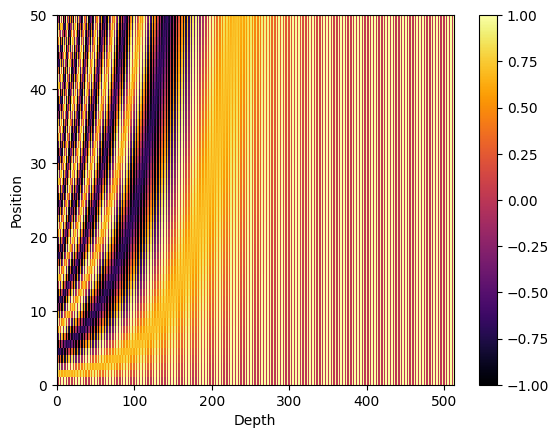

In [ ]:
# Generate a positional encoding tensor using the function
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

# Plot using pcolormesh
plt.pcolormesh(pos_encoding[0], cmap='inferno')
plt.xlim((0, 512))
plt.xlabel('Depth')
plt.ylabel('Position')
# Add a colorbar showing the color mapping
plt.colorbar()
plt.show()

<div style="line-height:0.2">
<h3 style="color:#FF7C00  "> Masking </h3>
<div style="line-height:1.2">
Mask all the padding in the batch of sequence will ensure that the model does not treat padding as the input. <br>
Where the pad value is 0, it masks outputs a 1. Where the pad value is 1, it masks outputs as a 0.
</div>
</div>

In [ ]:
def add_padding_mask(seq):
    """ Create a masking tensor to mask padded values in input sequence.

    Parameters:
        Input sequence [Tensor of shape [batch_size, seq_len]]

    Details:
        - tf.math.equal(seq, 0) compares each element of the seq tensor to 0. \\
            It returns booleans (still a tensor) indicating which elements are equal to 0 (the padding value).
        - tf.cast(..., tf.float32) casts the boolean tensor to float32 to convert True to 1 and False to 0.

    Returns:
        Masked values [Tensor of shape [batch_size, 1, 1, seq_len]
    """
    # Convert padded tokens to 1, non-padded to 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Add extra dimensions for padding (batch_size, 1, 1, seq_len)
    sequence = seq[:, tf.newaxis, tf.newaxis, :]
    return sequence

In [ ]:
# For example...
cons = tf.constant([[2, 5, 0, 0, 7], [3, 1, 4, 0, 0], [0, 0, 0, 6, 8]])
add_padding_mask(cons)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

<div style="line-height:0.2">
<h3 style="color:#FF7C00  "> Look-ahead mask </h3>
<div style="line-height:1.2">
It is necessary to mask the future tokens in a sequence when predicting. <br>
For instance, to predict the sixth word, the 1,2,3,4,5 words will be used.
</div>
</div>

In [ ]:
def add_look_ahead_mask(size):
    """Create a look-ahead mask for transformer self-attention.

    Parameters:
        Size of mask matrix / max sequence length

    Details: 
        - Create base mask matrix with ones
        - Create band part matrix setting upper triangle to zero
        - Invert 0s and 1s to get mask #(seq_len, seq_len)

    Returns:
        Mask matrix with 1s above diagonal and 0s below [tf.Tensor]
    """
    mask = tf.ones((size, size))
    mask = tf.linalg.band_part(mask, -1, 0)
    mask = 1 - mask
    return mask

In [ ]:
### For example...
ran = tf.random.uniform((1, 3))
temp = add_look_ahead_mask(ran.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

<div style="line-height:0.2">
<h2 style="color:#FF7C00  "> <b> Attention calculation </b> </h2>
<div style="line-height:1.2">
Attention => Scaled dot product of Queue, Key, Value vectors.    

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$
</div>
</div>


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """ Calculate Scaled dot-product attention.

    Details:
        - weights => q, k, v
            - q, k, v must have matching 1st dimensions. 
            - k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        
        - #1 Matrix multiplication of query and key transpose
        - #2 Scale matmul_qk by dimensions for stability
        - #3 Add masking to the scaled tensor
        - #4 Apply Softmax to normalize the logits (on the last axis (seq_len_k) so that the scores add up to 1)
        - #5 Multiply weights by value vectors
        
    Parameters:
        - query Tensor of shape == (..., seq_len_q, depth)
        - key Tensor of shape == (..., seq_len_k, depth)
        - value Tensor of shape == (..., seq_len_v, depth_v)
        - mask: Optional mask on the keys, values [Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k)
        
    Returns:
        - weighted values [Tensor of shape=[batch_size, num_queries, depth_per_key]]
        - attention weights [Tensor of shape=[batch_size, num_queries, num_keys]]
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    ## Scale
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    ## Mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [ ]:
def print_attention(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

<div style="line-height:0.2">
<h3 style="color:#FF7C00  "> Step #1 </h3>
<div style="line-height:1.2">

+ Define keys as a constant tensor of shape (4,3). Each row represents the weights of a key
+ Define values as a constant tensor of shape (4,2). Each row represents a value
+ Define query (temp_q) as a constant tensor of shape (1,3), representing the weights of the query
</div>
</div>

In [ ]:
# Set printing options to suppress scientific notation
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                    [0,10,0],
                    [0,0,10],
                    [0,0,10]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0],
                    [  10,0],
                    [ 100,5],
                    [1000,6]], dtype=tf.float32)  

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  
print_attention(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


<div style="line-height:0.2">
<h3 style="color:#FF7C00  "> Step #2 </h3>
<div style="line-height:1.2">
Redefine the query to be a constant tensor of shape (1,3), to represent a query where the weight is on the third key. <br> 
In this way, all associated values will get averaged.
</div>
</div>

In [ ]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_attention(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


<div style="line-height:0.2">
<h3 style="color:#FF7C00  "> Step #3 </h3>
<div style="line-height:1.2">
Redefine the query tensor to be a constant tensor of shape (1,3), 
to represent a query where the weights are on the first and second keys.
</div>
</div>

In [ ]:
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_attention(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


<div style="line-height:0.2">
<h3 style="color:#FF7C00  "> Step #4 </h3>
<div style="line-height:1.2">
Redefine the query tensor to be of shape (3,3).
</div>
</div>

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)
print_attention(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


<h2 style="color:#FF7C00  "> <u> <b> Multi-head attention</u> </b></h2> 

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """A custom layer implementing Multi-Head Attention. \\
    The class inherits from 'tf.keras.layers.Layer'. \\

    This layer implements the multi-head attention mechanism commonly used in transformer models \\
    for various natural language processing tasks. It projects input queries, keys, and values \\
    to a specified model dimension, splits them into multiple attention heads, computes attention \\
    scores and weights, and then combines the heads' outputs to generate the final attention output.

    Args:
        - Dimensionality of the model [int]
        - Number of attention heads to use [int]

    Attributes:
        - Number of attention heads [int]
        - Model's dimension [int]
        - Depth of each individual attention head [int]
        - wq: Dense layer for query projection [tf.keras.layers.Dense]
        - wk: Dense layer for key projection [tf.keras.layers.Dense]
        - wv: Dense layer for value projection [tf.keras.layers.Dense]
        - dense: Final Dense layer for output projection [tf.keras.layers.Dense]

    Methods:
        - split_heads(x, batch_size): Splits the last dimension of an input tensor into multiple \\
            heads and reorganizes dimensions for attention calculations.
        - call(v, k, q, mask): Performs multi-head attention on input values, keys, and queries.

    Returns:
        - The final attention output [tf.Tensor]
        - Attention weights computed during the attention calculation [tf.Tensor]
    """
    def __init__(self, d_model, num_heads):
        """ Constructor method, taking d_model (model dimension) and num_heads as arguments. """

        # Call the parent class constructor
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # Ensure d_model is divisible by num_heads
        assert d_model % self.num_heads == 0
        
        # Calculate depth per attention head
        self.depth = d_model // self.num_heads

        #### Create Dense layers for query, key, value projections + output
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)


    def split_heads(self, x, batch_size):
        """ Split the last dimension of the given tensor into multiple heads.

        Parameters:
            - Input tensor to be split [tf.Tensor]
            - atch size of the input [int]

        Details: 
            - Reshape the tensor to have the shape (batch_size, seq_len, num_heads, depth), \\
                where seq_len is the length of the sequence.
            - Transpose for proper dimensions.

        Returns:
            Reshaped tensor, with dimensions (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        tra = tf.transpose(x, perm=[0, 2, 1, 3])

        return tra

    def call(self, v, k, q, mask):
        """ Performs multi-head attention on input values, keys, and queries.

        Parameters:
            - Values tensor [tf.Tensor]
            - Keys tensor [tf.Tensor]
            - Queries tensor [tf.Tensor]
            - Mask for certain elements of the attention [tf.Tensor]

        Details: 
            - Get the batch size
            - Project queries using the Dense layer (batch_size, seq_len, d_model)
            - Project keys (batch_size, seq_len, d_model)
            - Project values (batch_size, seq_len, d_model)
            - Split queries, keys, and values into multi-head format # (batch_size, num_heads, seq_len_q, depth)
            - Calculate scaled dot-product attention and attention weights
            - Transpose attention output for proper dimensions
            - Reshape attention output for concatenation
            - Pass concatenated attention output through the Dense layer

        Returns:
            - The final attention output
            - Attention weights computed during the attention calculation [tf.Tensor]
        """
        batch_size = tf.shape(q)[0]
        ### Project
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        ### Split
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Calculate 
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # Transpose 
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # Reshape
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        # Pass to last
        output = self.dense(concat_attention)

        return output, attention_weights


<h3 style="color:#FF7C00  ">  Note:</h3>
<div style="margin-top: -8px;">
The MultiHeadAttention runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
# Create an instance of the MultiHeadAttention class with specified model dimension and number of heads
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

# Generate a random input tensor 'y' with shape (batch_size, encoder_sequence, d_model)
y = tf.random.uniform((1, 60, 512))

# Perform multi-head attention using the created instance. Pass 'y' as queries, keys, and values, and 'None' as the mask
out, attn = temp_mha(y, k=y, q=y, mask=None)

out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [ ]:
def create_feed_forward_network(d_model, dff):
    """ Create a feed-forward neural network for the transformer, consisting in two fully connected layers.

    Parameters:
        - Dmensionality of the model's output [int]
        - Number of units in the feed-forward layer [int]

    Returns:
        Sequential model consisting of a Dense layer with ReLU activation, followed by another Dense layer [tf.keras.Sequential]
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)                  # (batch_size, seq_len, d_model)
    ])

In [ ]:
sample_ffn = create_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

<div style="line-height:0.2">
<h3 style="color:#EF380D  "> <b> Build Encoder and Decoder </b></h3>
<div style="line-height:1.2">
Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask)
2.    Point wise feed forward networks.

<div style="line-height:0.7">
Each decoder layer consists of sublayers:
</div>
<div style="line-height:1.2">

1.   Masked multi-head attention (with look ahead mask and padding mask).
2.   Multi-head attention (with padding mask). <br>
    - V (value) and K (key) receive the encoder output as inputs. <br>
    - Q (query) receives the output from the masked multi-head attention sublayer. <br>
3.   Point wise feed forward networks.

</div>
</div>
</div>

<h3 style="color:#FF7C00  "> 1) Encoder layer </h3>

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """ Encoder layer in a transformer model. Class inherits from tf.keras.layers.Layer. \\
    It consists of multi-head self-attention followed by a point-wise feed-forward network. \\
    It applies layer normalization and dropout to stabilize and regularize the learning process.

    Args:
        - Dimensionality of the model [int]
        - Number of attention heads [int]
        - Dimension of the feed-forward network (dff) [int]
        - Dropout rate (optional, default: 0.1) [float]

    Attributes:
        - MultiHeadAttention instance [MultiHeadAttention object]
        - Point-wise feed-forward network [tf.keras.Sequential]
        - First layer normalization [tf.keras.layers.LayerNormalization]
        - Second layer normalization [tf.keras.layers.LayerNormalization]
        - First dropout layer [tf.keras.layers.Dropout]
        - Second dropout layer [tf.keras.layers.Dropout]

    Methods:
        call(x, training, mask): Apply the encoder layer's operations on the input.

    Returns:
        The final output tensor after encoder layer operations [tf.Tensor]
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """ Initializations. """
        # Call the parent class constructor
        super(EncoderLayer, self).__init__()
        
        # Create a MultiHeadAttention instance with given d_model and num_heads
        self.mha = MultiHeadAttention(d_model, num_heads)
        # Create a point-wise feed-forward network with specified d_model and dff
        self.ffn = create_feed_forward_network(d_model, dff)

        ## Create LayerNormalization layers with epsilon for stabilization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        ## Create Dropout layers with the given dropout rate
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training_yes_or_no, mask):
        """ Encode the input with multi-head attention.

        Parameters:
            - Input tensor [tf.Tensor]
            - Value to specify the model is in training mode [Bool]
            - Mask tensor for attention masking [tf.Tensor]

        Details: 
            - Apply multi-head attention on the input tensor x, using itself as queries, keys, and values \\
                (batch_size, input_seq_len, d_model)
            - Apply dropout
            - Add and normalize using LayerNormalization

            - Apply point-wise feed-forward network on the output from previous step (batch_size, input_seq_len, d_model)
            - Apply dropout
            - Add and normalize using LayerNormalization
        
        Returns:
            Final output after encoder layer operations [tf.Tensor]
        """
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training_yes_or_no)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training_yes_or_no)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

<h3 style="color:#FF7C00  "> 2) Decoder layer </h3>

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """ Single layer of the decoder in a transformer model.
        Class inherits from tf.keras.layers.Layer
        - multi-head self-attention 
        - multi-head attention with encoder output 
        - point-wise feed-forward network operations 
        - normalization 
        - dropout

    Args:
        - Dimensionality of the model [int]
        - Number of attention heads [int]
        - Dimension of the feed-forward network (dff) [int]
        - Dropout rate (default: 0.1) [float, optional]

    Attributes:
        - First multi-head attention instance [MultiHeadAttention]
        - Second multi-head attention instance [MultiHeadAttention]
        - Point-wise feed-forward network [tf.keras.Sequential]
        - First layer normalization [tf.keras.layers.LayerNormalization]
        - Second layer normalization [tf.keras.layers.LayerNormalization]
        - Third layer normalization [tf.keras.layers.LayerNormalization]
        - First dropout layer [tf.keras.layers.Dropout]
        - Second dropout layer [tf.keras.layers.Dropout]
        - Third dropout layer [tf.keras.layers.Dropout]

    Methods:
        call(x, enc_output, training, look_ahead_mask, padding_mask):\\
        Apply the decoder layer's operations on the input.

    Returns:
        - Final output tensor after decoder layer operations [tf.Tensor]
        - Attention weights from the first multi-head attention operation [tf.Tensor]
        - Attention weights from the second multi-head attention operation [tf.Tensor]
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """ Constructor. """
        # Call the parent class constructor
        super(DecoderLayer, self).__init__()

        ## Create MultiHeadAttention instances
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        # Create a point-wise feed-forward network
        self.ffn = create_feed_forward_network(d_model, dff)

        ### Create LayerNormalization layers with epsilon for stabilization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #### Create Dropout layers with the given dropout rate
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training_yes_or_no, look_ahead_mask, padding_mask):
        """ Decoder layer's operations on the input.

        Parameters:
            - Input x [tf.Tensor]
            - Encoder output tensor [tf.Tensor]
            - Value to specify if the model is in training mode or not [Bool]
            - Mask for look-ahead attention [tf.Tensor]
            - Mask for padding [tf.Tensor]

        Details: 
            - 1  
                - Apply multi-head attention within the decoder layer
                - Apply dropout
                - Add and normalize using LayerNormalization
            - 2
                - Apply multi-head attention to combine with encoder outputs
                - Apply dropout
                - Add and normalize using LayerNormalization
            - 3
                - Apply point-wise feed-forward network to the output of the previous step
                - Apply dropout
                - Add and normalize using LayerNormalization
        
        Returns:
            - Final output tensor after decoder layer operations [tf.Tensor]
            - Attention weights from the first multi-head attention operation [tf.Tensor]
            - Attention weights from the second multi-head attention operation [tf.Tensor]
        """
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training_yes_or_no)  
        out1 = self.layernorm1(attn1 + x)  
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training_yes_or_no)  
        out2 = self.layernorm2(attn2 + out1)  

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training_yes_or_no)  
        out3 = self.layernorm3(ffn_output + out2) 

        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

<div style="line-height:0.2">
<h3 style="color:#EF380D  "> <b> Encoder creation </b></h3>
<div style="line-height:1.2">

1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers
</div>
</div>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """ The Encoder component of a transformer model. \\
    Stack of identical EncoderLayers, with an embedding layer and positional encoding. \\
    It applies self-attention and feed-forward operations on the input.

    Args:
        - Number of EncoderLayers [int]
        - Dimensionality of the model [int]
        - Number of attention heads [int]
        - Dimension of the feed-forward network [int]
        - Vocabulary size of the input data [int]
        - Maximum position for positional encoding [int]
        - The dropout rate (default: 0.1) [float, optional]

    Attributes:
        -  Dimensionality of the model [int]
        -  Number of EncoderLayers in the Encoder [int]
        -  Embedding layer for input sequences [tf.keras.layers.Embedding]
        -  Positional encoding matrix [tf.Tensor]
        -  List of EncoderLayer instances [list]
        -  Dropout layer [tf.keras.layers.Dropout]

    Methods:
        call(x, training, mask): Apply the Encoder's operations on the input.

    Returns:
        Final output tensor after Encoder operations [tf.Tensor]
    """
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()  # Call the parent class constructor

        # Set class attributes
        self.d_model = d_model
        self.num_layers = num_layers

        # Create an embedding layer for input sequences
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        # Create a positional encoding matrix
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Create a list of EncoderLayer instances
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        # Create a dropout layer with the given dropout rate
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training_yes_or_not, mask):
        """ Encoder's operations on the input.

        Args:
            - The input tensor [tf.Tensor]
            - Value to check when the model is in training mode [bool]
            - A mask tensor to mask certain elements [tf.Tensor]

        Returns:
            The final output tensor after Encoder operations [tf.Tensor]
        """
        # Get the sequence length from the input tensor 'x'
        seq_len = tf.shape(x)[1]

        # Apply embedding and add positional encoding
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        # Apply dropout to the input
        x = self.dropout(x, training=training_yes_or_not)

        # Iterate through the list of EncoderLayer instances
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training_yes_or_not, mask)

        # Return the final output of the encoder (batch_size, input_seq_len, d_model)
        return x


<div style="line-height:0.2">
<h3 style="color:#EF380D  "> <b> Decoder creation </b></h3>
<div style="line-height:1.2">

1.  Output Embedding     
2.  Positional Encoding     
3.  N decoder layers   
</div>
</div>

In [ ]:
class Decoder(tf.keras.layers.Layer):
    """ The Decoder component of a transformer model. \\
    Stack of identical DecoderLayers, with an embedding layer and positional encoding. \\
    It applies self-attention, multi-head attention with encoder output, and feed-forward operations on the input.

    Parameters:
        - Number of DecoderLayers in the Decoder [int]
        - Dimensionality of the model [int]
        - Number of attention heads [int]
        - Dimension of the feed-forward network (dff) [int]
        - Vocabulary size of the target data [int]
        - Maximum position for positional encoding [int]
        - Dropout rate (default: 0.1) [float, optional]

    Attributes:
        - Dimensionality of the model [int]
        - Number of DecoderLayers in the Decoder [int]
        - Embedding layer for target sequences [tf.keras.layers.Embedding]
        - Positional encoding matrix [tf.Tensor]
        - List of DecoderLayer instances [list]
        - Dropout layer [tf.keras.layers.Dropout]

    Methods:
        call(x, enc_output, training, look_ahead_mask, padding_mask): Apply the Decoder's operations on the input.

    Returns:
        - Final output tensor after Decoder operations [tf.Tensor]
        - Attention weights from DecoderLayers [dict]
    """
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        """ Constructor. """
        # Call the parent class constructor
        super(Decoder, self).__init__()

        # Set class attributes
        self.d_model = d_model
        self.num_layers = num_layers

        # Create an embedding layer for target sequences
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        # Create a positional encoding matrix
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Create a list of DecoderLayer instances
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        # Create a dropout layer with the given dropout rate
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training_yes_or_not, look_ahead_mask, padding_mask):
        """ Decoder's operations on the input.

        Args:
            - Input x [tf.Tensor]
            - Encoder output [tf.Tensor]
            - Value to state whether the model is in training mode [Bool]
            - Mask for look-ahead attention [tf.Tensor]
            - Mask for padding [tf.Tensor]

        Returns:
            Final output tensor after Decoder operations [Tensor of shape (batch_size, target_seq_len, d_model)]
            Attention weights from DecoderLayers [dict]
        """
        # Get the sequence length from the input tensor 'x'
        seq_len = tf.shape(x)[1]
        # Create a dictionary to store attention weights
        attention_weights = {}

        # Apply embedding and add positional encoding to the input
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        # Apply dropout to the input
        x = self.dropout(x, training=training_yes_or_not)

        # Iterate through the list of DecoderLayer instances
        for i in range(self.num_layers):
            # Apply decoder layer operations and get attention weights
            x, block1, block2 = self.dec_layers[i](x, enc_output, training_yes_or_not, look_ahead_mask, padding_mask)

            # Store attention weights in the dictionary
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # Return the final output of the decoder and attention weights
        return x, attention_weights


In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500,
                        maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training_yes_or_not=False, mask=None)

# shape (batch_size, input_seq_len, d_model)
sample_encoder_output.shape

(64, 62, 512)


In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000,
                        maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, enc_output=sample_encoder_output, training_yes_or_not=False,look_ahead_mask=None, padding_mask=None)

# Shape
output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

<h3 style="color:#EF380D  "> <b> Transformer creation </b></h3>

In [ ]:
class Transformer(tf.keras.Model):
    """ The Transformer model that combines the Encoder and Decoder. \\
        Encoder + Decoder + final dense layer.

    Parameters:
        - Number of layers in both Encoder and Decoder [int]
        - Dimensionality of the model [int]
        - Number of attention heads [int]
        - Dimension of the feed-forward network [int]
        - Vocabulary size of the input data [int]
        - Vocabulary size of the target data [int]
        - Maximum position for positional encoding in the input [int]
        - Maximum position for positional encoding in the target [int]
        - Dropout rate (default: 0.1) [float, optional]

    Attributes:
        - Encoder instance [Encoder obj]
        - Decoder instance [Decoder obj]
        - Dense layer for final output [tf.keras.layers.Dense]

    Methods:
        call(inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
            Apply the Transformer's operations on the input.

    Returns:
        - Final output after Transformer operations [tf.Tensor]
        - Attention weights from DecoderLayers [dict]
    """
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        """ Constructor. """
        # Initialize the parent
        super(Transformer, self).__init__()

        # Create an Encoder instance
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        # Create a Decoder instance
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        # Create a dense layer for the final output
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training_or_not, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """ Encode and decode.

        Parameters:
            - Input tensor [tf.Tensor]
            - Target tensor [tf.Tensor]
            - Whether the model is in training mode [bool]
            - Mask for padding in encoder input (enc_padding_mask) [tf.Tensor]
            - Mask for look-ahead attention in decoder [tf.Tensor]
            - Mask for padding in decoder input [tf.Tensor]

        Details: 
            - Apply encoder operations to input data
            - Apply decoder operations to generate final output and attention weights
            - Apply a dense layer to get the final output

        Returns:
            - Final output tensor after Transformer operations [tf.Tensor]
            - Attention weights from DecoderLayers [dict]
        """
        enc_output = self.encoder(inp, training_or_not, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training_or_not, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

#N.B => fn_out shape is  (batch_size, tar_seq_len, target_vocab_size)
fn_out, _ = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None, 
            look_ahead_mask=None, dec_padding_mask=None)

fn_out.shape

In [ ]:
""" Hyperparameters """
num_layers = 4  #6
d_model = 128   #512
dff = 512       #2048
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_it.vocab_size + 2
dropout_rate = 0.1

<h3 style="color:#FF7C00  "> => Optimizer </h3>

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Learning rate schedule class for a Transformer model.

    Parameters:
        - Dimensionality of the model [tf.Tensor]
        - Number of warmup steps [int]

    Attributes:
        - Dimensionality of the model [tf.Tensor]
        - Number of warmup steps [int]

    Methods:
        __call__(step): Calculate and return the learning rate.

    Returns:
        Learning rate [tf.Tensor]
    """
    def __init__(self, d_model, warmup_steps=4000):
        # Call the constructor of the parent 
        super(CustomSchedule, self).__init__()

        ## Store the dimensionality of the model and cast it to float32
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        # Store the number of warmup steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """ Calculate and return the learning rate for the given step.
        
        This is typically used in learning rate warm-up strategies where the learning rate gradually increases\\
        at the beginning of training. The d_model typically represents the dimensionality of the model's hidden states.

        Parameters:
            Current optimization step [tf.Tensor]
        
        Details: 
            - Calculate the argument for the rsqrt function, to control the rate of decay as training progresses.\\
            It calculates the reciprocal square root of the input step. [1 / sqrt(step)]. 
            - Calculate the argument for the minimum function, multiplying the step by the reciprocal\\ 
            of self.warmup_steps raised to the power of -1.5.\\
            The goal is increasing the learning rate at the beginning of training.
            - Get the learning rate as product of_
                - Reciprocal square root of self.d_model (represents the dimensionality of the model's hidden states). 
                - Element-wise minimum between arg1 and arg2. to ensure that the learning rate does not increase too quickly.
        
        Returns:
            Learning rate [tf.Tensor]
        """
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lr_rate = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return lr_rate

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

<h3 style="color:#FF7C00  "> => Metrics </h3>

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def transformer_loss_function(real, pred):
    """ Calculate the loss for the predicted sequence compared to the target sequence.\\
    It is necessary to apply a padding mask when calculating the loss.
    
    Parameters:
        - target [tf.Tensor]
        - predicted [tf.Tensor]

    Details: 
        - Create a boolean mask where non-padding elements are True
        - Calculate the initial loss using the loss_object
        - Cast the mask to the data type of loss_
        - Multiply the loss with the mask to only consider non-padding elements
        - Calculate the mean loss over non-padding elements

    Returns:
        Loss value [tf.Tensor]
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    mean_loss_over = tf.reduce_sum(loss_) / tf.reduce_sum(mask)
    return mean_loss_over

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_loss

In [ ]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_accuracy

<h3 style="color:#FF7C00  "> => Training </h3>

In [ ]:
my_transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
                        pe_input=input_vocab_size, pe_target=target_vocab_size,rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    """ Create masks for input sequences and target sequences in a Transformer model.

    Parameters:
        - input [tf.Tensor]
        - target [tf.Tensor]

    Details:
        - dec_padding_mask:\\
        Used in the 2nd attention block in the decoder, to mask the encoder outputs.
        - combined_mask:\\
        Used in the 1st attention block in the decoder, to pad and mask future tokens in the input received by the decoder.

    Returns:
        - Mask for padding in encoder input [tf.Tensor]
        - Combined mask for decoder input [tf.Tensor]
        - Mask for padding in decoder input [tf.Tensor]
    """
    # Create a mask for padding in encoder input
    enc_padding_mask = create_padding_mask(inp)
    # Create a mask for padding in decoder input
    dec_padding_mask = create_padding_mask(inp)

    # Create a mask for look-ahead attention in decoder input
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # Create a mask for padding in decoder target
    dec_target_padding_mask = create_padding_mask(tar)
    # Combine the look-ahead mask and decoder target padding mask
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

<h3 style="color:#FF7C00  "> => Checkpoint </h3>

In [ ]:
""" Create the checkpoint path and the checkpoint manager, to save checkpoints every `n` epochs. """

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## Restore the latest checkpoint, if exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
""" Define the signature decoder for the train_step function. """
EPOCHS = 20
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

In [ ]:
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    """ Perform one training step for the Transformer model, with input signature.

    Parameters:
        - Input [tf.Tensor]
        - Target [tf.Tensor]

    Details:
        - Remove the last token from target for input
        - Remove the first token from target for target
        - Create masks for attention

        - Open a gradient tape to track operations for differentiation
            - Get predictions from the Transformer model
            - Calculate the loss using the loss function
    
        - Calculate gradients of the loss with respect to the model's trainable variables
        - Apply the calculated gradients to update model's trainable variables

        - Update train_loss metric with the calculated loss value
        - Update train_accuracy metric by comparing target and prediction


    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    # Calculate gradients 
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # Apply gradients 
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    ## Update train_loss and train_accuracy
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    if batch % 50 == 0:
        print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

<h3 style="color:#FF7C00  "> => Evaluation </h3>

In [ ]:
def evaluate_tranformer(inp_sentence):
    """ Perform evaluation using the Transformer model on an input sentence.

    Parameters:
        Input sentence [str]

    Returns:
        - Resulting output [tf.Tensor]
        - Attention weights [dict]
    """
    ## Define start + end tokens
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    ## Tokenize + preprocess the input sentence
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    ## Initialize the decoder input with the English start token
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        # Create masks for attention
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # Get predictions from the Transformer model
        predictions, attention_weights = transformer(encoder_input, output, False, 
                                                    enc_padding_mask, combined_mask, dec_padding_mask)

        # Select the last predicted word # (batch_size, 1, vocab_size)
        predictions = predictions[:, -1:, :]

        # Choose the word with highest probability as the predicted_id
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Check if the end token is predicted, return the result if so
        if predicted_id == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights

        # Concatenate the predicted_id to the output
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


<h3 style="color:#FF7C00  "> => Visualization </h3>

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
    """ Plot the attention weights for visualization.

    Parameters:
        - Dictionary containing attention weights [dict]
        - Input sentence [str]
        - Output tensor [tf.Tensor]
        - Layer index for which attention is plotted [int]
    """
    fig = plt.figure(figsize=(16, 8))

    # Tokenize the input sentence
    sentence = tokenizer_pt.encode(sentence)
    # Extract attention weights for the specified layer
    attention = tf.squeeze(attention[layer], axis=0)

    # Iterate through attention heads
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        ax.matshow(attention[head][:-1, :], cmap='winter')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        # Set x-axis labels with tokens
        ax.set_xticklabels(['<start>'] + [tokenizer_pt.decode([i]) for i in sentence] + ['<end>'], fontdict=fontdict, rotation=90)

        # Set y-axis labels with decoded tokens
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                        if i < tokenizer_en.vocab_size], fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))

    # Adjust layout
    plt.tight_layout()
    plt.show()


<h2 style="color:#FF7C00  "> <b> Main example <b> </h2>

In [ ]:
def translate(sentence, plot=''):
    """ Translate an input sentence using the Transformer model.

    Parameters:
        - Input sentence [str]
        - Layer index for plotting attention (plot) [str, optional (default: '')]

    """
    # Get translation and attention weights using the evaluate function
    result, attention_weights = evaluate(sentence)

    # Decode the predicted result into a human-readable sentence
    predicted_sentence = tokenizer_it.decode([i for i in result if i < tokenizer_it.vocab_size])

    # Print the input sentence and the predicted translation
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    # If plot is specified, plot the attention weights
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)


In [ ]:
translate("Non so cosa dirti.")

In [ ]:
translate("Questo è un problema tuo caro.")

In [ ]:
translate("Il dado è tratto.")